In [46]:
# imports
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, median_absolute_error

import sys

sys.path.append("..")
sys.path.append("../src")
from src.DataHandling.processing import supervised_transform
import src.DataHandling.visualization as vis

# models
from src.Models.baseline import Baseline
from src.Models.ma import MovingAverage
from src.Models.lr import Regression

In [47]:
# set global variables
TURBINE_ID_BRITISH = 2  ### set turbine id here, nb: you have to run the notebook 'data_inspection.ipynb' first
TURBINE_ID_BRAZILIAN = 1  ### set turbine id here, nb: you have to run the notebook 'data_inspection.ipynb' first
HORIZONS = ["10min", "Hourly", "Daily"]
RESULTS = {"British": None, "Brazilian": None}
WINDOW_SIZES = [1, 6, 10] ### specify window sizes to test
METRICS = ["RMSE", "MAE"] 
benchmarks = pd.read_csv("../results_wind.csv")

TEST_DATES = {
    "British": [
        pd.to_datetime(benchmarks["test_start"][0]),
        pd.to_datetime(benchmarks["test_end"][0]),
    ],
    "Brazilian": [
        pd.to_datetime(benchmarks["test_start"][3]),
        pd.to_datetime(benchmarks["test_end"][3]),
    ],
}

In [48]:
# create dataframes for British and Brazilian results
# create multiindex for results dataframe
index = pd.MultiIndex.from_product(
    [METRICS, HORIZONS, WINDOW_SIZES], names=["Metric", "Horizon", "Window Size"]
)

# create results dataframe for British data
RESULTS["British"] = pd.DataFrame(index=index)

if TURBINE_ID_BRITISH == 2:
    data_rmse = benchmarks["RMSE"][0:3].repeat(len(WINDOW_SIZES)).reset_index(drop=True)
    data_mae = benchmarks["MAE"][0:3].repeat(len(WINDOW_SIZES)).reset_index(drop=True)
    data_benchmarks = pd.concat([data_rmse, data_mae], axis=0)
    RESULTS["British"]["Benchmark"] = data_benchmarks.values

# create results dataframe for Brazilian data
RESULTS["Brazilian"] = pd.DataFrame(index=index)

if TURBINE_ID_BRAZILIAN == 1:
    data_rmse = benchmarks["RMSE"][3:6].repeat(len(WINDOW_SIZES)).reset_index(drop=True)
    data_mae = benchmarks["MAE"][3:6].repeat(len(WINDOW_SIZES)).reset_index(drop=True)
    data_benchmarks = pd.concat([data_rmse, data_mae], axis=0)
    RESULTS["Brazilian"]["Benchmark"] = data_benchmarks.values

# make horizons a categorical index
cat_index = pd.CategoricalIndex(HORIZONS, categories=HORIZONS, ordered=True)
RESULTS["British"].index = RESULTS["British"].index.set_levels(cat_index, level=1)
RESULTS["Brazilian"].index = RESULTS["Brazilian"].index.set_levels(cat_index, level=1)
# sort wrt index
RESULTS["British"].sort_index(inplace=True)
RESULTS["Brazilian"].sort_index(inplace=True)

In [49]:
# load cleaned data
turbine_brit = pd.read_csv(f"../data/cleaned/turbine_brit_{TURBINE_ID_BRITISH}.csv")
turbine_braz = pd.read_csv(f"../data/cleaned/turbine_braz_{TURBINE_ID_BRAZILIAN}.csv")

# use date column as index and convert to datetime
turbine_brit["Date"] = pd.to_datetime(turbine_brit["Date"])
turbine_brit.set_index("Date", inplace=True)

turbine_braz["Date"] = pd.to_datetime(turbine_braz["Date"])
turbine_braz.set_index("Date", inplace=True)

DATA = {"British": turbine_brit, "Brazilian": turbine_braz}

For understandibility.... models do transformation to a supervised learning problem inherently...

In [50]:
# transform data into a supervised learning problem
X, y = supervised_transform(
    df=turbine_brit, target_var="Power (kW)", time_steps_ahead=1, window_size=5
)

# 1. Baseline Model

The simplest model involves using the latest available value as prediction, which, in our scenario, is stored in the 'Power (kW) (time -1)' column.

In [51]:
Baseline.evaluate_model_(DATA, TEST_DATES, RESULTS)

# 2. Moving Average

**Explanation of the Model:** 

In contrast to the Baseline model, the Moving Average model offers the flexibility of selecting a window size. This window size determines the number of preceding time steps taken into account for generating forecasts. Furthermore, there is an option to specify a discount factor (default = 1), which regulates the extent of reduction in influence for more distant past time steps. This strategy is similar to how a discount factor is used in calculating future rewards within the framework of reinforcement learning. Note that when a window size of one is chosen, the Moving Average model is identical with the Baseline model.

In [52]:
MovingAverage.evaluate_model_(DATA, TEST_DATES, RESULTS)

# 3. Different kinds of Linear Regression

In [53]:
Regression.evaluate_model_(DATA, TEST_DATES, RESULTS) ### TODO: look into warnings

/opt/miniconda3/envs/res_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+07, tolerance: 9.485e+06
  model = cd_fast.enet_coordinate_descent(
/opt/miniconda3/envs/res_env/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.426e+07, tolerance: 9.485e+06
  model = cd_fast.enet_coordinate_descent(


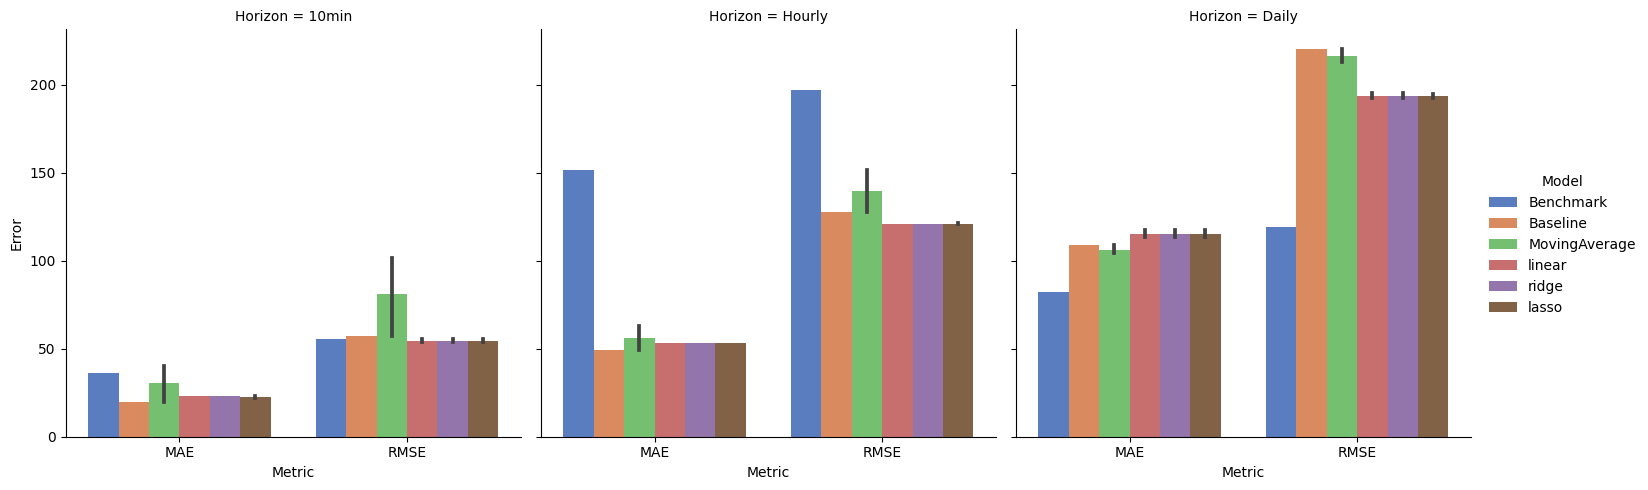

In [54]:
vis.barplot_errors(
    RESULTS["Brazilian"],
    ["Benchmark", "Baseline", "MovingAverage", "linear", "ridge", "lasso"],
    col="Horizon",
)

In [55]:
# TODO: less features yield better results for linear regression. why?
# TODO: try different window sizes for the models (where possible)
# TODO: do hyperparameter tuning for the models
# TODO: try the transfer learning approach

In [56]:
RESULTS["Brazilian"]

Benchmark    Baseline  MovingAverage      linear  \
Metric Horizon Window Size                                                      
MAE    10min   1             36.244988   20.000000      20.000000   23.334578   
               6             36.244988   20.000000      31.666667   22.882507   
               10            36.244988   20.000000      40.400000   22.896418   
       Hourly  1            151.508157   49.000000      49.000000   53.498407   
               6            151.508157   49.000000      56.166667   53.526265   
               10           151.508157   49.000000      62.900000   53.475714   
       Daily   1             81.943719  109.000000     109.000000  117.191197   
               6             81.943719  109.000000     105.500000  113.624332   
               10            81.943719  109.000000     104.500000  114.365441   
RMSE   10min   1             55.417200   57.449244      57.449244   55.644458   
               6             55.417200   57.449244      84.100158   54.023523   
               10            55.417200   57.449244     101.694512   54.037488   
       Hourly  1            196.741606  127.394988     127.394988  121.136294   
               6            196.741606  127.394988     140.123668  120.962459   
               10           196.741606  127.394988     151.517685  120.824209   
       Daily   1            119.249865  220.426094     220.426094  195.088587   
               6            119.249865  220.426094     214.766735  193.055129   
               10           119.249865  220.426094     213.149667  192.314097   

                                 ridge       lasso  
Metric Horizon Window Size                          
MAE    10min   1             23.334433   22.971898  
               6             22.882185   22.099781  
               10            22.896414   22.246765  
       Hourly  1             53.497688   53.486535  
               6             53.528679   53.268601  
               10            53.474826   53.308825  
       Daily   1            117.189333  117.203925  
               6            113.622705  113.596064  
               10           114.366827  114.159217  
RMSE   10min   1             55.644457   55.652110  
               6             54.023452   54.037498  
               10            54.037419   54.040693  
       Hourly  1            121.136306  121.174399  
               6            120.962443  120.932884  
               10           120.824194  120.836095  
       Daily   1            195.088486  194.952099  
               6            193.055099  192.909821  
               10           192.314072  192.174333